# Import Statements

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.preprocessing import image
from tensorflow import data as tf_data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-04-22 08:49:55.910507: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 08:49:56.434059: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 08:49:56.436897: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 08:49:58.405501: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Image Directory Setup

In [2]:
image_size = (224,224)
batch_size = 10

In [1]:
import keras
from keras.preprocessing import image

# Assuming image_size and batch_size are defined somewhere in your code
image_size = (224, 224)
batch_size = 32

train_dir = '/mnt/c/users/efazh/DataProblems/Datasets/ComputerVision/Covid19-dataset/train'
test_dir = '/mnt/c/users/efazh/DataProblems/Datasets/ComputerVision/Covid19-dataset/test'

train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",  # Subset should be "training" for the training dataset
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",  # Subset should be "validation" for the validation dataset
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

2024-04-25 19:33:14.852817: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-25 19:33:14.977354: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-25 19:33:14.986215: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 19:33:17.338372: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 242 files belonging to 3 classes.
Using 194 files for training.


2024-04-25 19:33:19.424389: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 19:33:19.424857: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 242 files belonging to 3 classes.
Using 48 files for validation.
Found 63 files belonging to 3 classes.


In [4]:
train_ds.class_indices

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}

# Model Augmentation

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import RandomFlip, RandomRotation, RandomZoom

# Define augmentation layers
augmentation_layers = [
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2)
]

# Define ImageDataGenerator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=augmentation_layers,
    validation_split=0.2
)

# Load training data with validation split and augmentation
train_generator = train_datagen.flow_from_directory(
    '/mnt/c/users/efazh/DataProblems/Datasets/ComputerVision/Covid19-dataset/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Load validation data
val_generator = train_datagen.flow_from_directory(
    '/mnt/c/users/efazh/DataProblems/Datasets/ComputerVision/Covid19-dataset/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.


In [ ]:
# Fetch two images from the augmented generator
images, labels = next(train_generator)

# Plot the two images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i in range(2):
    axes[i].imshow(images[i])
    axes[i].axis('off')
    axes[i].set_title(f'Label: {labels[i]}')

plt.show()

## Creating Augmented Model (Simple CNN)

In [6]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model

# Define input shape
input_shape = (224, 224, 3)

# Define input layer
inputs = Input(shape=input_shape)

# Define augmentation layers (a bit buggy, will fix later 4/17)
'''
x = RandomFlip("horizontal", seed=42)(inputs)
x = RandomRotation(0.2, seed=42)(x)
x = RandomZoom(0.2, seed=42)(x)
x = RandomHeight(0.2, seed=42)(x)
x = RandomWidth(0.2, seed=42)(x)
x = Rescaling(1/255.)(x)
'''
# Convolutional layers
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

# Flatten the output of the convolutional layers
x = Flatten()(x)

# Fully connected layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
outputs = Dense(3, activation='softmax')(x)  # Output layer with softmax activation for 3 classes

# Define the model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

2024-04-22 08:50:25.794099: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 08:50:25.795253: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856 

## Fitting Augmented Model

In [8]:
# Define number of epochs
epochs = 13

# Fit the model to the training data
history = model.fit(
    train_ds,
    steps_per_epoch = 8,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/13


2024-04-17 13:24:17.194558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - ETA: 0s - loss: 1.5971 - accuracy: 0.3875

2024-04-17 13:24:24.266855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - 9s 1s/step - loss: 1.5971 - accuracy: 0.3875 - val_loss: 1.0806 - val_accuracy: 0.4545
Epoch 2/13
8/8 [==============================] - 7s 872ms/step - loss: 1.0001 - accuracy: 0.5634 - val_loss: 0.8989 - val_accuracy: 0.6212
Epoch 3/13
8/8 [==============================] - 8s 963ms/step - loss: 0.7061 - accuracy: 0.7750 - val_loss: 0.5840 - val_accuracy: 0.7121
Epoch 4/13
8/8 [==============================] - 8s 960ms/step - loss: 0.4198 - accuracy: 0.8875 - val_loss: 0.6154 - val_accuracy: 0.6515
Epoch 5/13
8/8 [==============================] - 8s 947ms/step - loss: 0.4249 - accuracy: 0.8375 - val_loss: 0.5416 - val_accuracy: 0.7727
Epoch 6/13
8/8 [==============================] - 7s 895ms/step - loss: 0.3474 - accuracy: 0.8732 - val_loss: 0.6016 - val_accuracy: 0.7727
Epoch 7/13
8/8 [==============================] - 7s 917ms/step - loss: 0.4379 - accuracy: 0.8250 - val_loss: 0.4581 - val_accuracy: 0.7424
Epoch 8/13
8/8 [==================

# Plotting Loss Curves

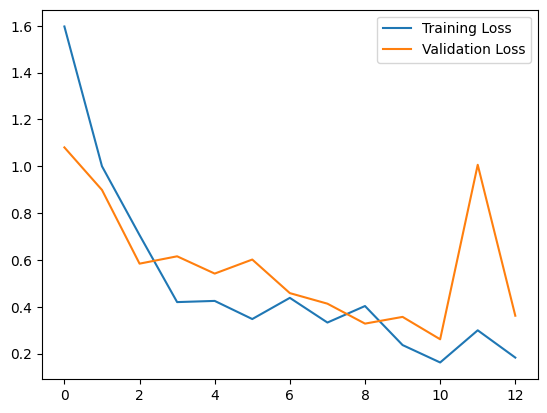

In [9]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

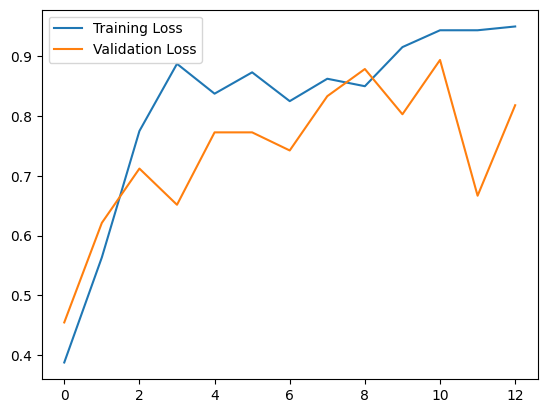

In [10]:
plt.plot(range(len(history.history["accuracy"])),history.history["accuracy"],label="Training Loss")
plt.plot(range(len(history.history["val_accuracy"])),history.history["val_accuracy"],label="Validation Loss")
plt.legend()